In [1]:
import tensorflow as tf
import os
import glob
import shutil
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import seaborn as sns
from tqdm.notebook import tqdm
import pydicom  as dicom
import cv2
from PIL import Image


In [2]:
input_path = "../input/rsna-miccai-brain-tumor-radiogenomic-classification/"
train_labels_file = "train_labels.csv"

train_labels = pd.read_csv(input_path + train_labels_file)
train_labels

 # MGMT_Class = 0 refers to people who do not have the MGMT promoter methylation. 
 # MGMT_Class = 1 appears to be someone who has the MGMT promoter methylation.

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


In [3]:
test_labels_file = "sample_submission.csv"

test_labels = pd.read_csv(input_path + test_labels_file)
test_labels

,BraTS21ID,MGMT_value
0,1,0.5
1,13,0.5
2,15,0.5
3,27,0.5
4,37,0.5
...,...,...
82,826,0.5
83,829,0.5
84,833,0.5
85,997,0.5


In [4]:
def plot_examples(row, cat):

    folder = str(train_labels.loc[row, 'BraTS21ID']).zfill(5)
    path_file = ''.join([input_path, 'train/', folder, '/', cat, '/'])
    images = os.listdir(path_file)
    
    fig, axs = plt.subplots(1, 5, figsize=(30, 10))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    
    for num in range(5):
        data_file = dicom.dcmread(path_file+images[num])
        img = data_file.pixel_array
        axs[num].imshow(img, cmap='gray')
        axs[num].set_title(cat+' '+images[num])
        axs[num].set_xticklabels([])
        axs[num].set_yticklabels([])
        axs[num].grid(False)
    
    plt.suptitle("MRI "+cat+" Scan for patient "+folder,
                 fontsize=18, color="#0b0a2d",
                 x=.5, y=.8)

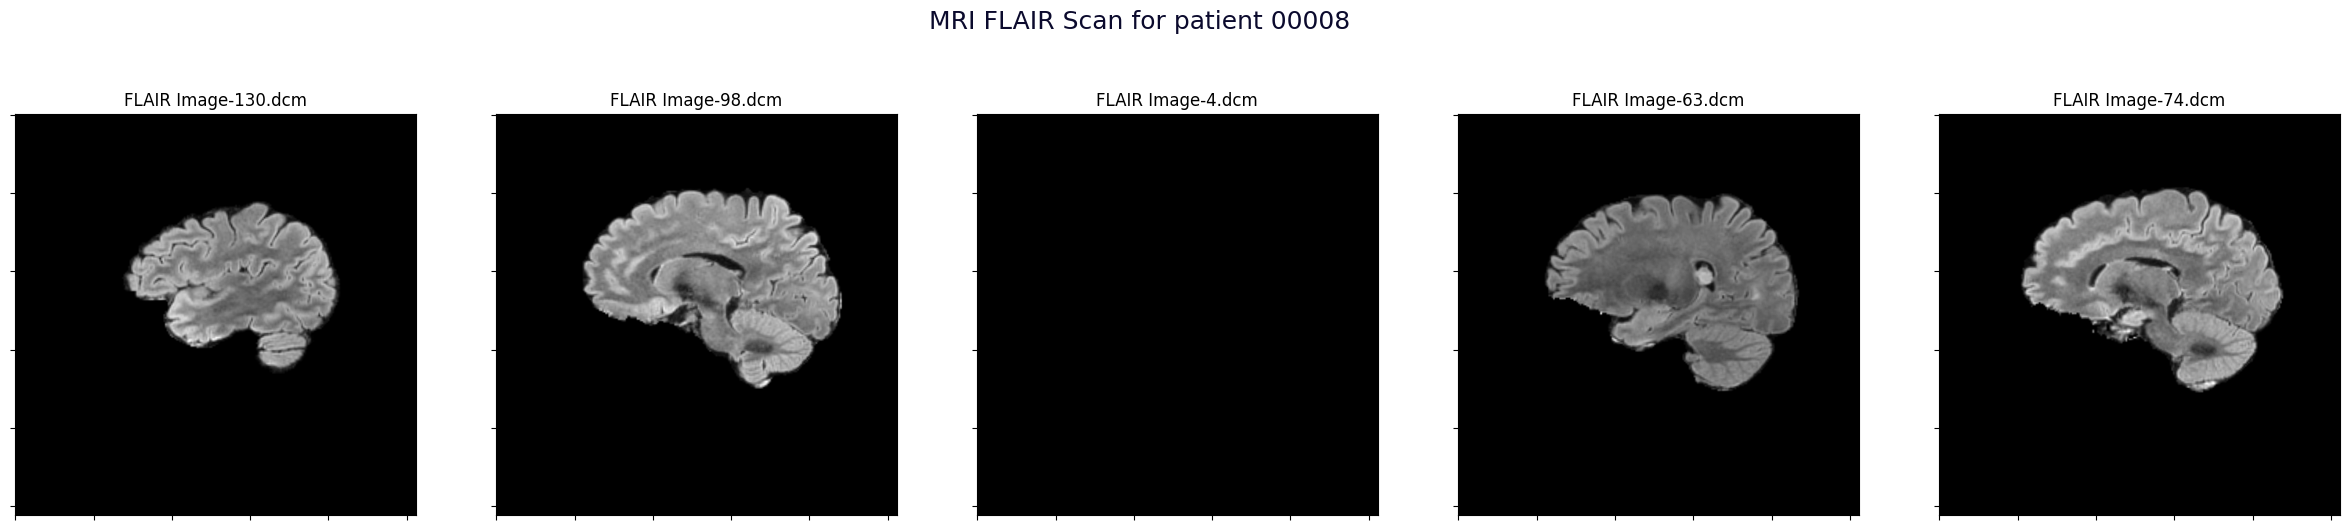

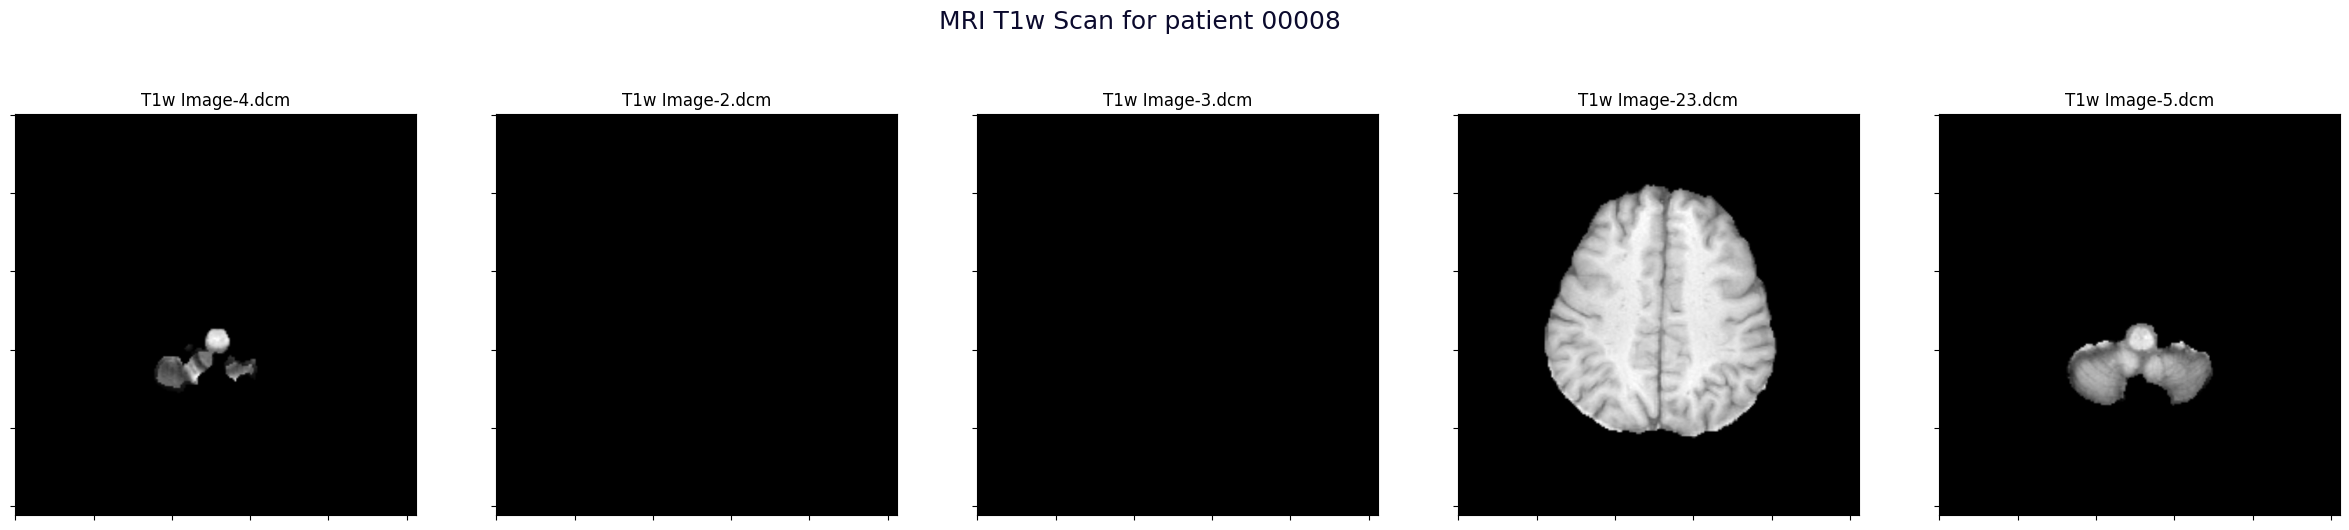

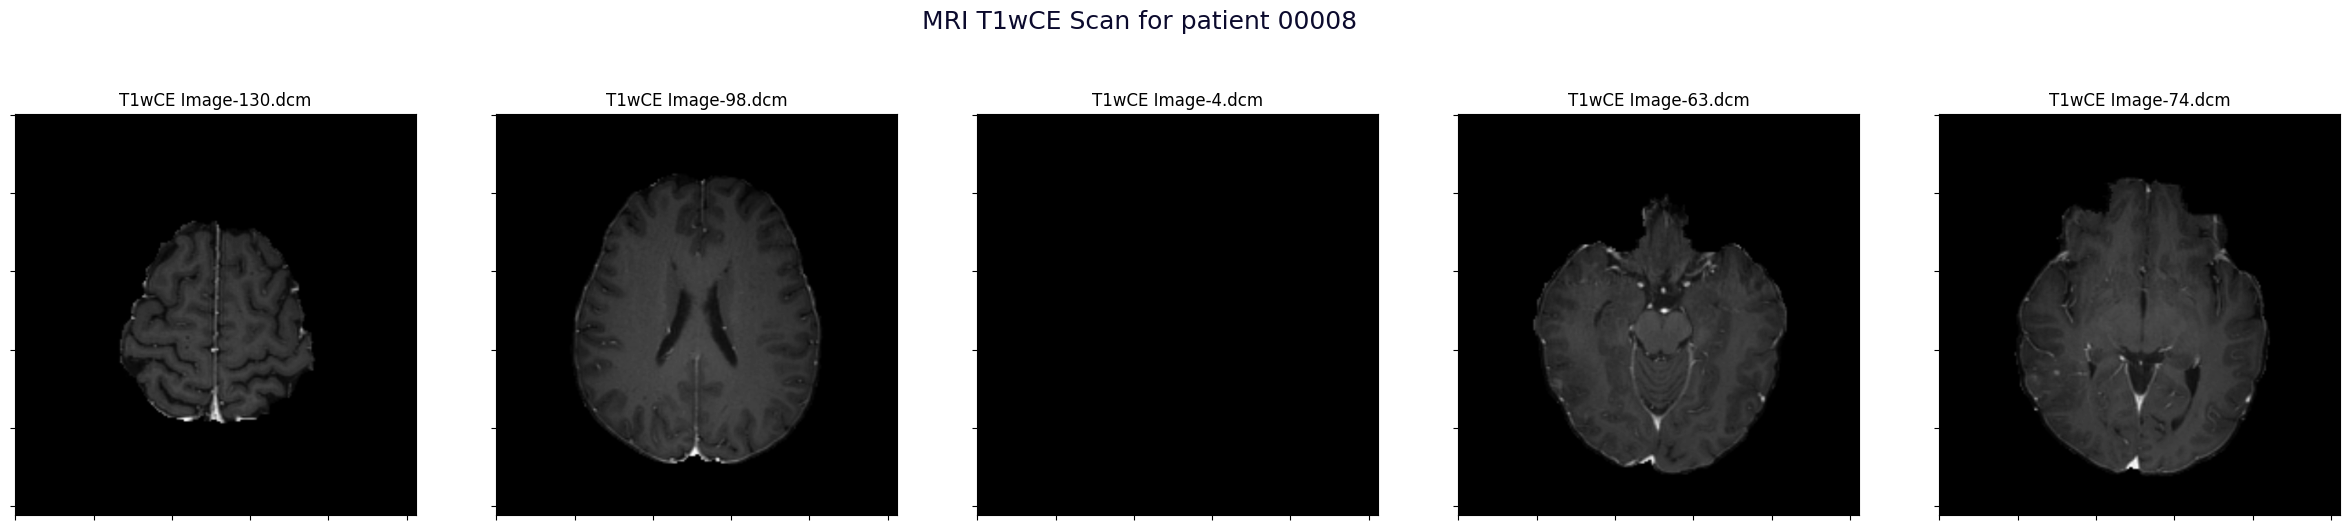

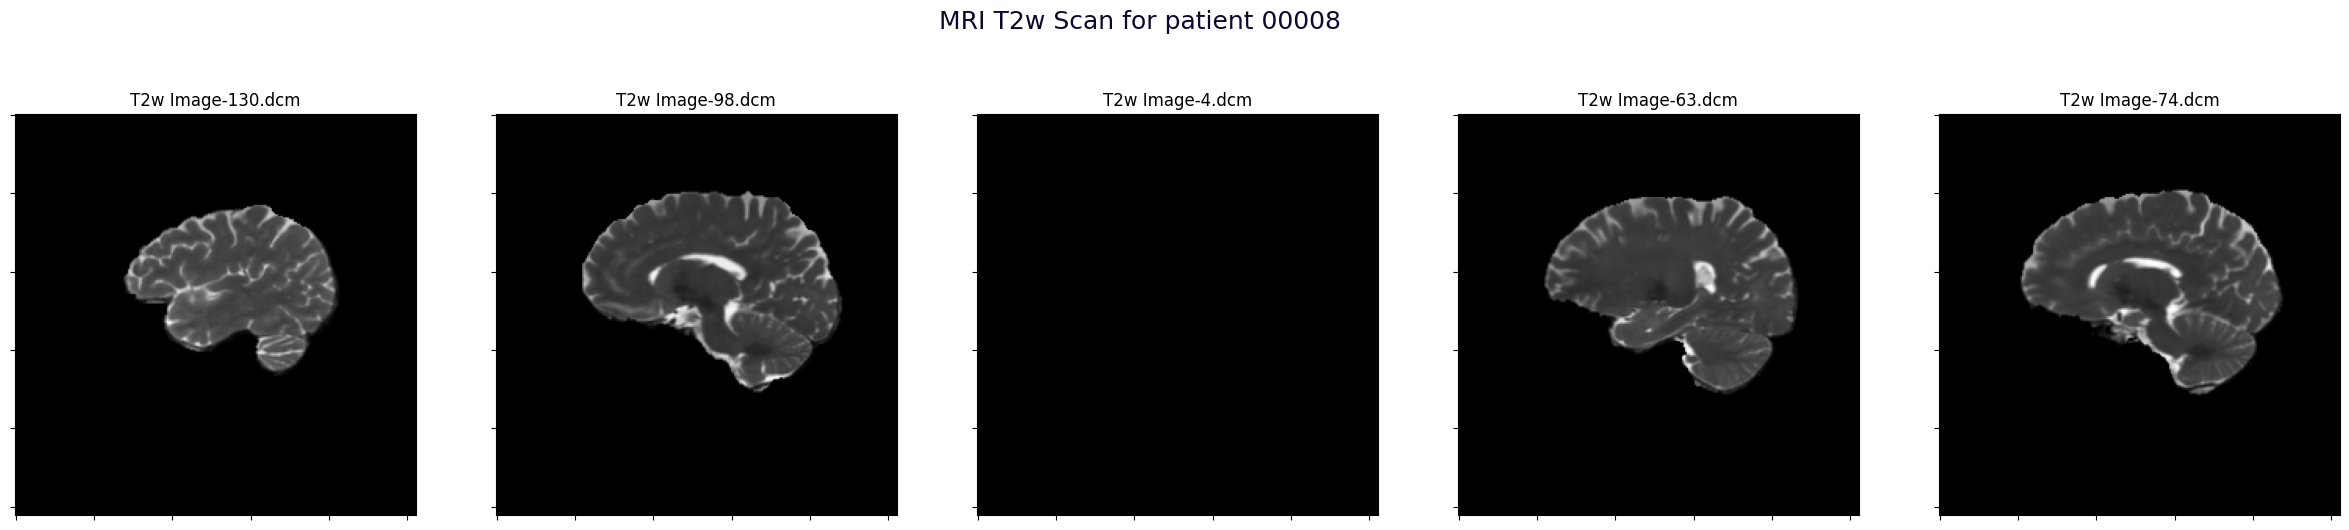

In [5]:
plot_examples(row = 5, cat = 'FLAIR')
plot_examples(row = 5, cat = 'T1w')
plot_examples(row = 5, cat = 'T1wCE')
plot_examples(row = 5, cat = 'T2w')

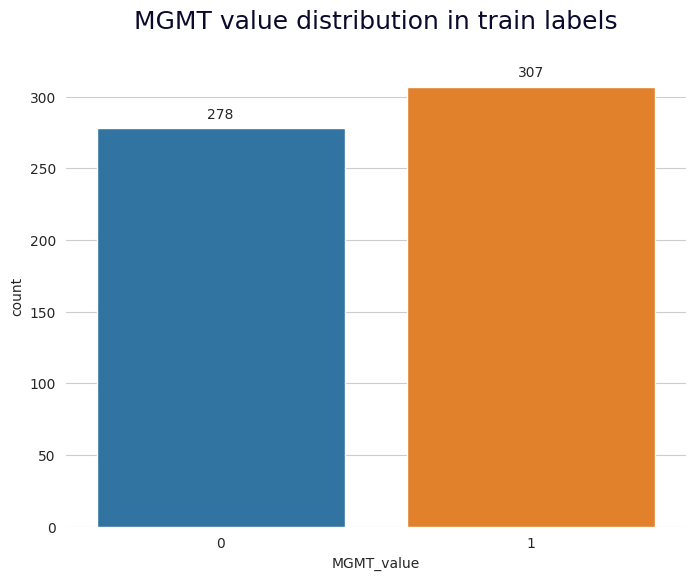

In [6]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(8,6))

ax = sns.countplot(data=train_labels, x="MGMT_value")
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
        ha = 'center', va = 'center', 
        xytext = (0, 10), 
        textcoords = 'offset points')

sns.despine(left=True, bottom=True)
plt.title("MGMT value distribution in train labels\n",
          fontsize=18, color="#0b0a2d")
plt.show()

In [7]:
def brain_mri_preprocessor(dicom_path):
    # Load the DICOM image
    dicom_data = dicom.dcmread(dicom_path)
    img = dicom_data.pixel_array  # Convert DICOM to NumPy array

    # Normalize pixel values to 0-255
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Threshold to create a binary mask (everything non-black is white)
    _, thresh = cv2.threshold(img, 10, 255, cv2.THRESH_BINARY)

    # Find contours of the white regions (brain)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Get the bounding box around the largest contour (assumed to be the brain)
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))

        # Crop the image using the bounding box
        cropped_img = img[y:y+h, x:x+w]
        cropped_img = img_cropped = cv2.resize(cropped_img, (244, 244), interpolation = cv2.INTER_AREA)

        return cropped_img
    else:
        return img  # Return original if no contours are found

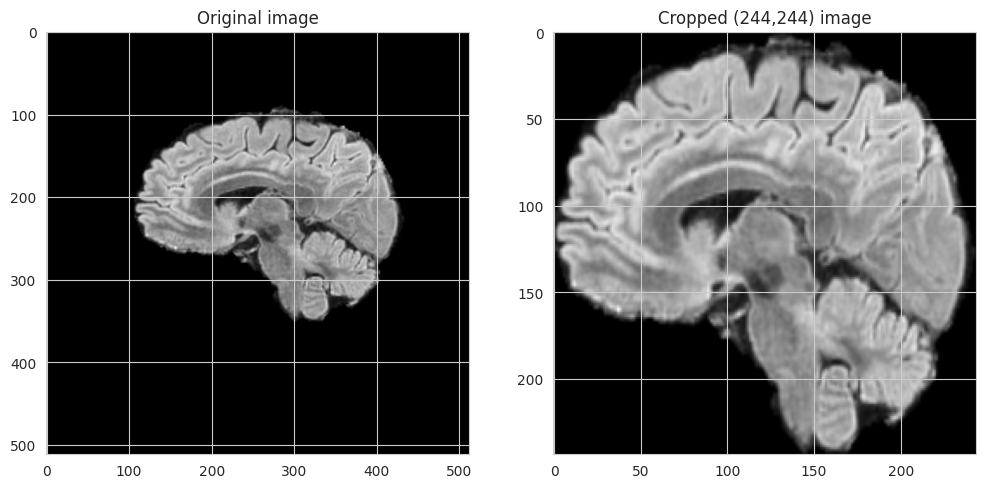

In [8]:
sample_img_path = ''.join([input_path, 'train/00008/FLAIR/Image-80.dcm'])
sample_img = dicom.dcmread(sample_img_path)
sample_img = sample_img.pixel_array

fig = plt.figure(figsize=(12,6))
ax = plt.subplot(1,2,1)
ax.imshow(sample_img, cmap='gray')
ax.set_title("Original image")

ax1 = plt.subplot(1,2,2)
img_cropped = brain_mri_preprocessor(sample_img_path)
ax1.imshow(img_cropped, cmap='gray')
ax1.set_title("Cropped (244,244) image")
plt.show()